In [33]:
import xarray as xr
import zarr
import glob
import pandas as pd
import numpy as np
import hvplot.pandas
import holoviews as hv
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import ipywidgets as widgets
import seaborn as sns
import cmocean
from datetime import datetime, timedelta

In [34]:
import warnings
warnings.filterwarnings('ignore')

Every year around February thousands of turtle hatchlings are born on the beaches of Northern KwaZulu-Natal. From here they enter the Indian Ocean and begin their journey south hitching a ride on the warm Agulhas Current. Little is known about the fate of these hatchlings save for the fact that only very few will make it to adulthood. One of the major obstacles these hatchlings face is being swept out of the warm agulhas current and into colder waters were they become hypothermic. Some of these hatchlings become stranded on beaches of the Western Cape where volunteers endevour to save them. The lucky few hatchlings which are found alive are brought to the Two Oceans Aquarium in Cape Town where they are rehabilitatad before they are strong enough to be released back into the wild. Monitoring such a vast coastline is however a mamoth task. Currently the program relies upon citizen reports from people happen across the stranded hatchlings, however recently the turtle team has had some succcess monitoring weather patterns and disspatching teams to turtle stranding hotspots when they think a stranding event may take place. At present this is however a very informal process and is believed could be improved upon by making better tools available to the turtle rescue teams. 

In [35]:
stranding_data = pd.read_csv('2015_2021_hatchling_stranding_summary.csv', names = ['Id', 'Date','Species','Location'])

I will only consider the Caretta Caretta species in a bid to reduce noise as this is by far the dominant species

In [36]:
display(stranding_data.Species.value_counts() )

Caretta caretta         622
Dermochelys coriacea      6
Name: Species, dtype: int64

In [37]:
stranding_data = stranding_data.loc[stranding_data['Species'] == 'Caretta caretta']

In [38]:
stranding_data['Date'] = pd.to_datetime(stranding_data['Date']) #coerce all dates to standard format
stranding_data = stranding_data.dropna(subset = ['Date']) #remove entries with no specified date

In [39]:
stranding_data.loc[stranding_data['Location'] == 'Mosselbay', 'Location'] = 'Mossel Bay'
stranding_data.loc[stranding_data['Location'] == 'Witsand', 'Location'] = 'Witsands'
stranding_data.loc[stranding_data['Location'] == 'Tenikwa PLETT', 'Location'] = 'Plettenberg Bay'
stranding_data.loc[stranding_data['Location'] == 'Tenikwa', 'Location'] = 'Plettenberg Bay'

Records have been kept of where and when stranding have occured over the past 6 years

In [40]:
display(stranding_data)

,Id,Date,Species,Location
0,2021_01,2021-04-03,Caretta caretta,Plett
2,2021_03,2021-03-28,Caretta caretta,Struisbaai
3,2021_04,2021-03-29,Caretta caretta,Stilbaai
4,2021_05,2021-03-29,Caretta caretta,Stilbaai
5,2021_06,2021-03-04,Caretta caretta,Struisbaai
...,...,...,...,...
625,NaN,2015-06-12,Caretta caretta,Plettenberg Bay
626,NaN,2015-06-20,Caretta caretta,Kommetjie
627,NaN,2015-07-22,Caretta caretta,Plettenberg Bay
628,NaN,2015-10-17,Caretta caretta,Struisbaai


First lets consider the locations of the strandings 

In [41]:
display(stranding_data.Location.value_counts() )

Struisbaai             329
Mossel Bay              45
Muizenberg              38
Witsands                35
Plettenberg Bay         22
Arniston                22
Hermanus                18
Gaansbaai               12
Sedgefield              11
Strandfontein            8
Scarborough              8
Kommetjie                7
Fish Hoek                6
Knysna                   5
Stilbaai                 5
Plett                    4
Cape Agulhas             3
Stillbaai                3
Vleesbaai                3
Glencairn                3
Simons Town              2
Wilderness               2
Grotto Beach             2
Buffels Bay              2
Unknown                  1
Table Bay                1
Gordans Bay              1
Aghulas                  1
Milnerton                1
Blouberg                 1
Camps Bay                1
Blombos                  1
Smitswinkel              1
Kleinmond                1
Clovelly                 1
Sandy Bay                1
St Francis               1
K

Struisbaai is by far the most common stranding location presumably because of it's southerly geographic position, below the locations with more than 10 strandings recoded have been plotted

In [42]:
stranding_data = stranding_data.groupby('Location').filter(lambda x: len(x) >= 10) #consider only loactions with greater then 10 strandings

In [43]:
latlong_dict = {}
latlong_dict['Struisbaai'] = [-34.80, 20.10]
latlong_dict['Mossel Bay'] = [-34.15, 22.20]
latlong_dict['Muizenberg'] = [-34.11, 18.52]
latlong_dict['Witsands'] = [-34.41, 20.92]
latlong_dict['Arniston'] = [-34.67, 20.27]
latlong_dict['Plettenberg Bay'] = [-34.07, 23.44]
latlong_dict['Hermanus'] = [-34.44, 19.25]
latlong_dict['Sedgefield'] = [-34.10, 22.78]
latlong_dict['Gaansbaai'] = [-34.64, 19.35]

In [44]:
stranding_count = stranding_data.Location.value_counts() 

In [45]:
location = []
lats = []
lons = []
count = []
for index, n in stranding_count.items():
    location.append(index)
    lats.append(latlong_dict[index][0])
    lons.append(latlong_dict[index][1])
    count.append(n)

Text(0.5, 1.0, 'Location of Turtle Hatchling Strandings in the Western Cape')

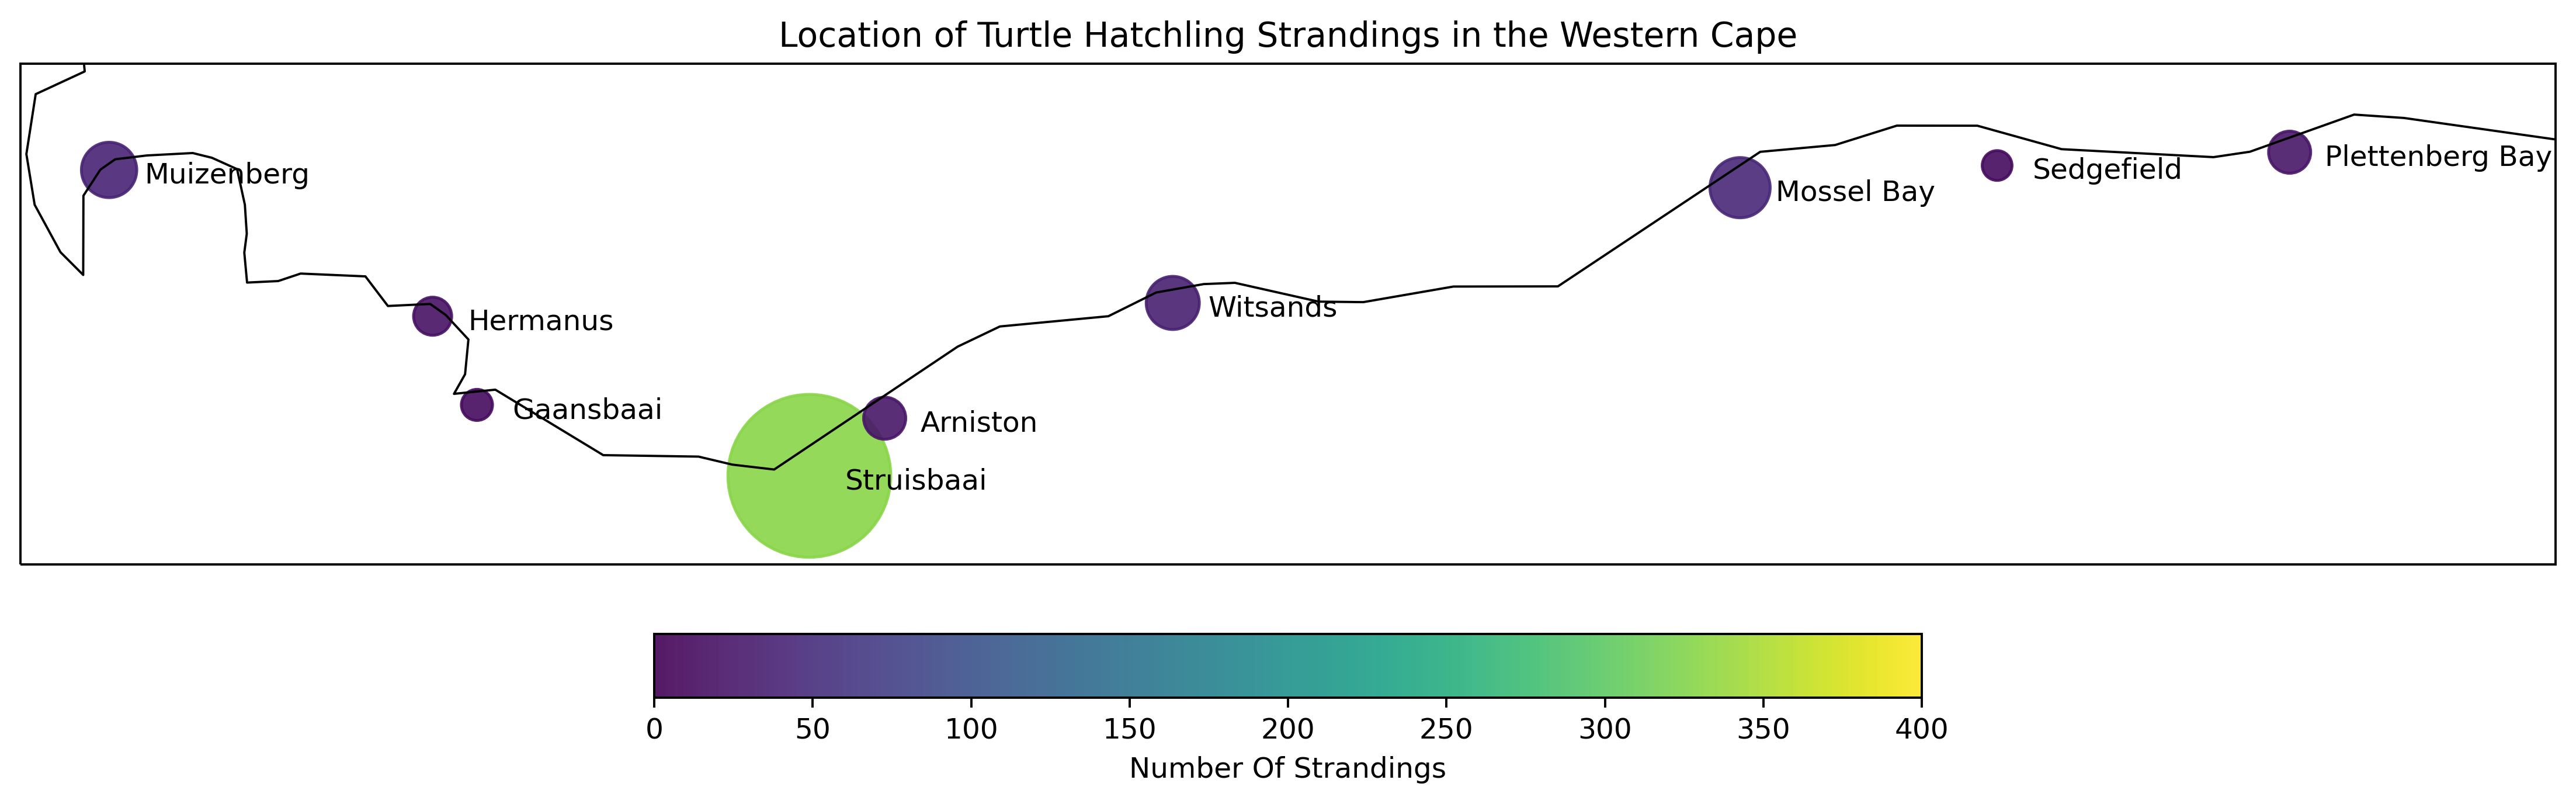

In [46]:
fig = plt.figure(figsize=(16,9), dpi = 350)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('50m', linewidth=0.8)

extent = (np.min(lons)-0.2,np.max(lons)+0.6, np.min(lats)-0.2,np.max(lats)+0.2)
ax.set_extent(extent)

scatterplot = ax.scatter(x = lons, y = lats, c=count, s = [x*10 for x in count], cmap = 'viridis', vmin = 0, vmax = 400, alpha=0.9,transform=ccrs.PlateCarree())

for loc,lat,lon in zip(location, lats, lons):
    ax.text(lon+0.08, lat-0.03, str(loc))

plt.colorbar(scatterplot, shrink = 0.5, orientation = 'horizontal', label = 'Number Of Strandings', pad=0.05)

plt.title('Location of Turtle Hatchling Strandings in the Western Cape')

In [47]:
extent

(18.32, 24.040000000000003, -35.0, -33.87)

Some years are seen to have vastly more strandings than other years, while strandings primarily occur in the months March, April and May

In [48]:
stranding_freq = stranding_data.groupby(stranding_data.Date).count()['Species'].rename('Standings')

def make_plot(Frequency):
    if Frequency == 'Weekly':
        return stranding_freq.groupby(stranding_freq.index.isocalendar().week).sum().hvplot.bar().opts(title = 'Weekly Strandings')
    elif Frequency == 'Monthly':
        return stranding_freq.groupby(stranding_freq.index.month).sum().hvplot.bar().opts(title = 'Monthly Strandings', xlabel = 'Month')
    else:
        return stranding_freq.groupby(stranding_freq.index.isocalendar().year).sum().hvplot.bar().opts(title = 'Annual Strandings')
        
        
widgets.interact(make_plot, Frequency = ['Weekly','Monthly','Annual']);

interactive(children=(Dropdown(description='Frequency', options=('Weekly', 'Monthly', 'Annual'), value='Weekly…

This is true across all stations with more than 10 strandings recorded

In [49]:
def make_plot2(Location, Frequency):
    location_data = stranding_data.loc[stranding_data['Location'] == str(Location)]
    location_freq = location_data.groupby(location_data.Date).count()['Species'].rename('Standings')
    if Frequency == 'Weekly':
        return location_freq.groupby(location_freq.index.isocalendar().week).sum().reindex(np.linspace(1,52,52, dtype = int) , fill_value=0).hvplot.bar().opts(title = 'Weekly Strandings in '+str(Location))
    elif Frequency == 'Monthly':
        return location_freq.groupby(location_freq.index.month).sum().reindex(np.linspace(1,12,12, dtype = int) , fill_value=0).hvplot.bar().opts(title = 'Monthly Strandings in '+str(Location), xlabel = 'Month')
    else:
        return location_freq.groupby(location_freq.index.isocalendar().year).sum().hvplot.bar().opts(title = 'Annual Strandings in '+str(Location))
        
        
widgets.interact(make_plot2, Location=list(latlong_dict.keys()), Frequency = ['Weekly','Monthly','Annual']);

interactive(children=(Dropdown(description='Location', options=('Struisbaai', 'Mossel Bay', 'Muizenberg', 'Wit…

This is presumably due to the drift rate of the hatchling taking approximately 1 month to traverse the eastern coast of South Africa before arriving at the colder waters of the Western Cape 

In [50]:
files = glob.glob('/mnt/kingfast1TB/ERA5/ERA5_*.zarr')
files.sort()
files = files[:-1]
ds = xr.open_mfdataset(files, engine="zarr")

extent2 = [extent[0]-2, extent[1]+4, extent[2]-3, extent[3]+1]

ds = ds.sel(lat = slice(extent2[3],extent2[2])).sel(lon = slice(extent2[0],extent2[1]))
ds['t2m'] = ds['t2m'] - 273.15
ds['sst'] = ds['sst'] - 273.15
ds['u10'] = ds['u10']*1.94384
ds['v10'] = ds['v10']*1.94384

def wind_speed(U, V):
    func = lambda x, y: np.sqrt(x**2 + y**2)
    return xr.apply_ufunc(func, U, V, dask = 'parallelized')

def wind_dir(U, V):
    func = lambda x, y: np.mod(180+np.rad2deg(np.arctan2(x, y)),360)
    return xr.apply_ufunc(func, U, V, dask = 'parallelized')

ds['ws'] = wind_speed(ds.u10, ds.v10)
ds['dir'] = wind_dir(ds.u10, ds.v10)

During Autumn, the peak of hatchling strandings the Agulhas current is less defined than in Summer and Winter.

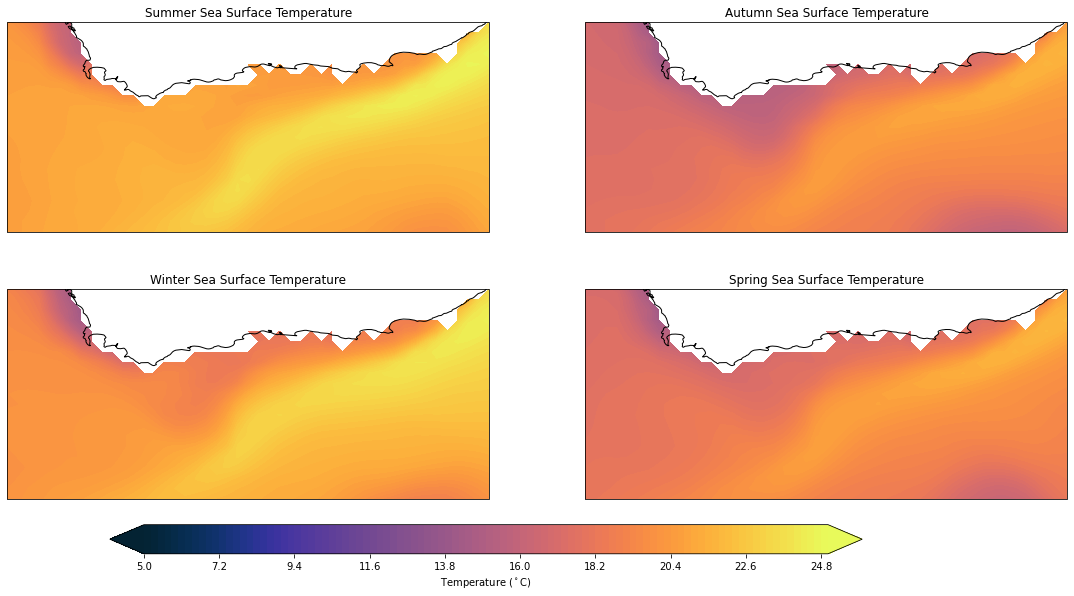

In [51]:
season_dict = {'Summer':0,
               'Autumn':1,
               'Winter':2,
               'Spring':3}


sst = {}
for Season in ['Summer','Autumn','Winter', 'Spring']:
    sst[Season] = (ds.sst.groupby(ds.time.dt.season).mean()[season_dict[Season]])# - ds.sst.mean(dim ='time'))

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(19,9))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

levels = np.linspace(5, 25, 101)

for i,season in enumerate(['Summer','Autumn','Winter', 'Spring']):
        cs=axs[i].contourf(ds.lon,ds.lat, sst[season],
                          transform = ccrs.PlateCarree(),
                          cmap=cmocean.cm.thermal,extend='both', levels = levels)
        axs[i].set_title(season + ' Sea Surface Temperature')
        axs[i].coastlines()

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.05, 0.55, 0.045])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal', label = 'Temperature ($^\circ$C)')


Let's Start with Struisbaai and see if there is a regular anomaly on days that hatchlings have been found stranded. We will only consider strandings that occured during Autumn (March,April,May) to remove noise induced by seasonality in climate variables

In [52]:
ds = ds.load()

In [53]:
#ds.to_netcdf('ERA5_reanalysis_East_Coast.nc')

In [54]:
ds

<xarray.Dataset>
Dimensions:  (lat: 21, lon: 47, time: 61200)
Coordinates:
  * lat      (lat) float64 -33.0 -33.25 -33.5 -33.75 ... -37.5 -37.75 -38.0
  * lon      (lon) float64 16.5 16.75 17.0 17.25 17.5 ... 27.25 27.5 27.75 28.0
  * time     (time) datetime64[ns] 2015-01-01 ... 2021-12-31T23:00:00
Data variables:
    sst      (time, lat, lon) float32 20.26 20.07 19.98 ... 19.64 20.34 21.03
    t2m      (time, lat, lon) float32 19.92 19.89 19.9 ... 18.27 18.25 18.04
    u10      (time, lat, lon) float32 2.592 2.415 2.286 ... -4.935 -4.025 -3.642
    v10      (time, lat, lon) float32 14.41 13.74 12.97 ... -15.84 -15.96 -15.48
    ws       (time, lat, lon) float32 14.64 13.95 13.17 ... 16.59 16.46 15.9
    dir      (time, lat, lon) float32 190.2 190.0 190.0 ... 17.31 14.16 13.24
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Mar 02 08:19:14 2022: cdo -f nc -copy ERA5/var165.grb E...
    institution:  European Centre for Medium-Range Weather Forecasts

In [24]:
ocean_lons = ds.sst[0].dropna(dim = 'lat', how = 'any').dropna(dim = 'lon', how = 'any').lon.values
ocean_lats = ds.sst[0].dropna(dim = 'lat', how = 'any').dropna(dim = 'lon', how = 'any').lat.values

def return_nearest_ocean_latlon(latlon):
    ocean_lat = min(ocean_lats, key=lambda x:abs(x-latlon[0]))
    ocean_lon = min(ocean_lons, key=lambda x:abs(x-latlon[1]))
    return [ocean_lat,ocean_lon]


ocean_latlong_dict = {}
for index in latlong_dict:
    ocean_latlong_dict[index] = return_nearest_ocean_latlon(latlong_dict[index])

In [25]:
ds_struis = ds
ds_struis = ds_struis.sel(lat = ocean_latlong_dict['Struisbaai'][0], method = 'nearest').sel(lon = ocean_latlong_dict['Struisbaai'][1], method = 'nearest')
ds_struis_d = ds_struis.resample(time = 'D', closed = "right").mean().load()

In [26]:
ds_struis_mam = ds_struis_d.where(ds_struis.time.dt.season == 'MAM').dropna(dim='time', how = 'all')

strandings = list(set(stranding_data.loc[stranding_data['Location'] == 'Struisbaai'].Date))
march = [x for x in strandings if x.month == 3]
april = [x for x in strandings if x.month == 4]
may = [x for x in strandings if x.month == 5]
dates = march + april + may
dates.sort()

The below plots provide a comparison of distribution of common weather variables during autumn and autumn days where turtle hatchlings have been found stranded. A higher peak in the distrobution curve indicates this climate state is more common. A positve northward wind component (known as v-wind or meridional wind) corresponds to a Southerly wind, while a positive eastward wind (known as u-wind or zonal wind) would correspond to a westerly wind. Thus a strong South Easter would have a strong positive northward component and strongly negative eastward component. This brain teaser is because we refer to the direction wind is coming from rather than the direction of travel that these vector components refer to. In the case of Struisbaai an onshore wind, which intuitively one would associate with strandings) would have a strong posive northward component and negative eastward component (provided the strandings are occuring on the Eastern side of the peninsula).

This plot takes some time to load so please be patient after adjusting lag.

In [27]:
def make_kde_plot(lag):
    dates_1 = [date + timedelta(days = lag) for date in dates]
    ds_s = ds_struis_d.sel(time = dates_1)
    def make_plot():
        fig, axs = plt.subplots(nrows=3,ncols=2,figsize=(16,12))
        axs=axs.flatten()
        for i,var in enumerate(['sst','t2m','ws','dir','u10','v10']):
            sns.kdeplot(ds_struis_mam[str(var)].values, ax = axs[i], label = 'Autumn Daily Mean')
            sns.kdeplot(ds_s[str(var)].values, ax = axs[i],  label = 'Hatchling Stranding Daily Mean')
            #axs[i].set_title(str(var))
            axs[i].legend()
        axs[0].set_xlabel('Sea Surface Temperature ($^\circ$C)')
        axs[1].set_xlabel('Air Temperature ($^\circ$C)')
        axs[2].set_xlabel('Wind Speed (knots)')
        axs[3].set_xlabel('Wind Direction')
        axs[4].set_xlabel('Eastward Wind Component (knots)')
        axs[5].set_xlabel('Northward Wind Component (knots)')
        
        fig.suptitle('Hatchling Stranding Date defined as '+str(lag)+' Days From Being Rescued', fontsize=14, fontweight='bold')
    return(make_plot())

widgets.interact(make_kde_plot, lag=-1);

interactive(children=(IntSlider(value=-1, description='lag', max=1, min=-3), Output()), _dom_classes=('widget-…

Below the atmospheric conditions over the previous 7 days since a hatchling was rescued in Struisbaai have been plotted. The dates have been ordered from most to least number of hatchling being rescued. 

Have now incorporated wind direction and absolute speed

In [28]:
struis_df = stranding_data.loc[stranding_data['Location'] == 'Struisbaai']

d = {'date': dates, 'strandings': [len(struis_df.loc[struis_df['Date'] == d]) for d in dates]}
d = pd.DataFrame(data=d)
dates_sorted = list(d.sort_values(by=['strandings'], ascending=False).date) #this sorts from most to least strandings

In [31]:
d

,date,strandings
0,2015-03-20,1
1,2015-04-07,3
2,2015-04-10,68
3,2015-04-13,1
4,2015-04-15,1
5,2015-04-16,6
6,2015-04-17,5
7,2015-04-18,2
8,2015-04-22,34
9,2015-04-23,4


In [29]:
def line_plot(stranding_date):
    date = stranding_date
    date_7 = date + timedelta(days = -7)
    d = ds_struis.sel(time = slice(str(date_7), str(date)))
    def make_line_plot():
        fig,axs = plt.subplots(figsize=(21,9), nrows=1,ncols=2)
        axs=axs.flatten()
        d.sst.plot(color = 'blue', ax = axs[0], label = 'Sea Surface Temperature')
        d.t2m.plot(color = 'black', ax = axs[0], label = 'Air Temperature')
        axs[0].grid(axis = 'y')
        axs[0].legend()
        #axs[0].set_ylim(15,25)
        axs[0].set_ylabel('Temperature ($^\circ$C)')
        d.ws.plot(color = 'red', ax = axs[1], label = 'Wind Speed')
        ax3 = axs[1].twinx()
        d.dir.plot(color = 'green', ax = ax3, label = 'Wind Direction')
        #axs[1].set_ylim(-40,50)
        axs[1].set_ylabel('Velocity (m/s)')
        ax3.set_ylabel('Wind Direction')
        ax3.legend()
        axs[1].grid(axis = 'y')
        axs[1].legend()
        num = len(struis_df.loc[struis_df['Date'] == date])
        plt.suptitle('Conditions over previous 7 days since '+ str(num)+' hathlings were rescued on the '+str(date)+' in Struisbaai')
    return make_line_plot()

widgets.interact(line_plot, stranding_date=dates_sorted);

interactive(children=(Dropdown(description='stranding_date', options=(Timestamp('2015-04-10 00:00:00'), Timest…

#then an ML model perhaps random forest

Designing a prediction model for hatchling strandings can be approach from several different ways. Again we will only consider Struisbaai as this is where the most data is available. Next we will divide the data into fifths, 4/5 for training of models and 1/5 for assessing the performance of the model. 

In [27]:
df = d.set_index('date')

In [28]:
train = df.iloc[:-11]
test = df.iloc[-11:]

In [29]:
index = pd.date_range(train.index[0], train.index[-1])
train = train.reindex(index).fillna(0)

index = pd.date_range(test.index[0], test.index[-1])
test = test.reindex(index).fillna(0)

In [30]:
ds_struis_7 = ds_struis_d#.rolling(time=2).sum()

In [31]:
def get_mam(df):
    march = df[df.index.month == 3]
    april = df[df.index.month == 4]
    may = df[df.index.month == 5]
    mam = march.append(april).append(may)
    mam = mam.sort_index()
    return mam

In [32]:
for var in ['sst','t2m','ws','dir','u10','v10']:
    train[var] = ds_struis_7[var].sel(time = train.index)
    test[var] = ds_struis_7[var].sel(time = test.index)

In [33]:
train = get_mam(train)
test = get_mam(test)

train_features = np.array(train[['v10']])
train_labels = np.array(train[['strandings']])

test_features = np.array(test[['v10']])
test_labels = np.array(test[['strandings']])

The simplest way to model anything is to just predict the mean will occur. the case of the turtle strandings to predict 0.58 hatchlings will strand on struisbaai every day of the autumn will produce an absolute error of:

In [34]:
# The baseline predictions are the historical averages
baseline_preds = train_labels.mean()
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print(round(np.mean(baseline_errors), 2))

0.74


However in fact predicting no hatchlings will strand at all will infact perform better:

In [35]:
round(np.mean(np.abs(0 - test_labels)), 2)

0.26

The next simplest way could be to create a linear model with a single variable

In [36]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [37]:
for var in ['sst','t2m','ws','dir','u10','v10']:
    train_features = np.array(train[[var]])
    train_labels = np.array(train[['strandings']])
    test_features = np.array(test[[var]])
    test_labels = np.array(test[['strandings']])
    regr = linear_model.LinearRegression()
    # Train the model using the training sets
    lm = regr.fit(train_labels, train_features)
    # Make predictions using the testing set
    pred_labels = regr.predict(test_features)
    errors = abs(pred_labels - test_labels)
    # Print out the mean absolute error (mae)
    print(str(var), 'Mean Absolute Error:', round(np.mean(errors), 2))
    print("Model slope:" ,np.round(lm.coef_[0][0],2))

sst Mean Absolute Error: 18.59
Model slope: -0.01
t2m Mean Absolute Error: 18.02
Model slope: 0.0
ws Mean Absolute Error: 11.91
Model slope: -0.11
dir Mean Absolute Error: 118.25
Model slope: -0.33
u10 Mean Absolute Error: 0.95
Model slope: -0.03
v10 Mean Absolute Error: 0.99
Model slope: -0.0


However in this case with little signal from just a single days worth of meteorological variables the 'line of best fit' is just a verticle line with near zero gradient across all variables essentialy predicting the same number of strandings regardless of meteorological conditions

Perhaps a random forest model which seeks to catagorize climate conditions as a function of the number of strandings

In [38]:
from sklearn.ensemble import RandomForestRegressor

In [39]:
for x in range(1,22):
    for var in ['sst','t2m','ws','dir','u10','v10']:
        train[str(var)+'_'+str(x)] = ds_struis_7[var].sel(time = train.index - timedelta(days=x))
        test[str(var)+'_'+str(x)] = ds_struis_7[var].sel(time = test.index - timedelta(days=x))

In [40]:
day = {}
error = {}
for l in [10,50,100,250,500]:
    day[l] = []
    error[l] = []
    for i in range(22):
        sel_var=['sst','u10','v10']
        for x in range(1,i+1):
                for var in ['sst','u10','v10']:
                    sel_var.append(str(var)+'_'+str(x))
        #sel_var = ['u10','v10']
        train_features = np.array(train[sel_var])
        train_labels = np.array(train[['strandings']])
        test_features = np.array(test[sel_var])
        test_labels = np.array(test[['strandings']])
        # Instantiate model with 1000 decision trees
        rf = RandomForestRegressor(n_estimators = l, random_state = 42)
        # Train the model on training data
        rf.fit(train_features, train_labels);
        # Use the forest's predict method on the test data
        predictions = rf.predict(test_features)
        # Calculate the absolute errors
        errors = abs(predictions - test_labels)
        # Print out the mean absolute error (mae)
        day[l].append(i)
        #print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
        error[l].append(np.mean(errors))

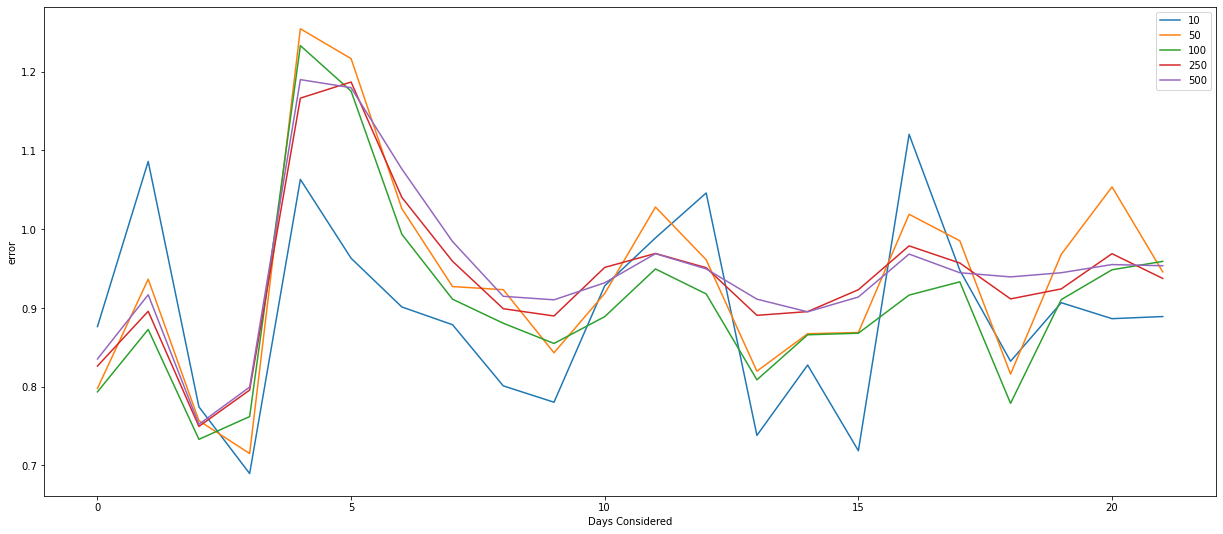

In [41]:
plt.figure(figsize=(21,9))
for index in day:
    plt.plot(day[index],error[index], label = str(index))
plt.ylabel('error')
plt.xlabel('Days Considered')
plt.legend()

None of these random forest models perform well 

In [42]:
sel_var=['sst','u10','v10']
for x in range(1,4):
        for var in ['sst','u10','v10']:
            sel_var.append(str(var)+'_'+str(x))
#sel_var = ['u10','v10']
train_features = np.array(train[sel_var])
train_labels = np.array(train['strandings'])
test_features = np.array(test[sel_var])
test_labels = np.array(test['strandings'])
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 10, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
#Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.6 degrees.


In [43]:
df = pd.DataFrame({'day': range(len(predictions)), 'predictions' : list(predictions), "test_labels": list(test_labels)})

In [44]:
df = df.set_index('day')

In [45]:
df = df.where(df>1)#.dropna(how = 'all')

In [46]:
#df = df.reset_index()

Plenty of false positives but few false negatives so perhaps there is some hope

Text(0, 0.5, 'Number of Turtles Stranded')

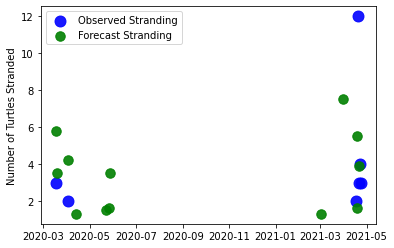

In [47]:
plt.scatter(test.index, df.test_labels, s = 120, color = 'blue', alpha = 0.9, label = 'Observed Stranding')
plt.scatter(test.index, df.predictions, s=90, color = 'green', alpha = 0.9, label = 'Forecast Stranding')
plt.legend()
plt.ylabel('Number of Turtles Stranded')

Next up is a neural net or more specifically a Multi-layer Perceptron regressor. Here hopefully the individual node layers may more succesfully identify the conditions in which strandings occur